In [4]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import operator as op
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../cow.py

# Optimization

In [27]:
import collections

In [147]:
# 21 from Hamming Code
# Quantize comes from quantizing to only try 100 (rate, blocklength) pairs
class node_table():
    op_SNR = arange(-2, 15, 0.01)
#     padd = 0.1*10**(-9)
    
    # num_nodes = n
    def __init__(self, n, down=True):
        self.num_node = n
        minb = n * 160 * 7 / 4
        quantize = max((20000-minb*2)/100, 21)
        bitrange = arange(minb, 20000-minb, int(quantize))
        self.bitrange = bitrange
#         rate = num_node * 160 / bitrange * 7 / 4
#         blocklength = bitrange / 21
        num_tables = len(bitrange)
#         print('num tables', num_tables)
#         print('the blocklength range', floor(bitrange/21))
        self.tables = {}
        for bidx in range(num_tables):
            b = int(bitrange[bidx])
            block = b/21 if down else b/21/n
            self.tables[b] = hs_rs_table(self.op_SNR, n*160/b, int(block))
#             codetable = self.tables[b]
#             actualSNR = codetable[0][np.where(np.array(codetable[1])<=self.padd)[0][0]]
#             print(b, actualSNR)

In [113]:
%%time
n30 = node_table(30)

CPU times: user 52min 1s, sys: 35.2 s, total: 52min 37s
Wall time: 57min 59s


In [137]:
def optimization(num_nodes):
#     SNR_range = arange(-1, 15, 0.1)
    #downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
    downtarget, uptarget = 1 * 10**(-9), 1 * 10**(-9)
    filename = '../data_tables/optimization/n' + str(num_nodes) + '.in'
    downNode = load_table(filename)
    for SNR in SNR_range:
        downbit, upbit = float("inf"), float("inf")
        for bit in downNode.tables.keys():
            bittable = downNode.tables[bit]
            func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if func(SNR) <= downtarget:
                downbit = bit
                break
        for bit in upNode.tables.keys():
            bittable = upNode.tables[bit]
            func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if func(SNR) <= uptarget:
                upbit = bit
                break
        xorbit = 20000 - downbit - upbit
        # do xor analysis
        # if func(SNR) <= target: save bit1, bit2, alpha, beta
    pass

In [120]:
filename = '../data_tables/optimization/n' + str(30) + '.in'
save_table(n30, filename)

In [121]:
for num_nodes in arange(1, 36):
    node = node_table(num_nodes)
    filename = '../data_tables/optimization/n' + str(num_nodes) + '.in'
    save_table(node, filename)

KeyboardInterrupt: 

In [148]:
%%time
for num_nodes in arange(1, 36):
    node = node_table(num_nodes, False)
    filename = '../data_tables/optimize_up/n' + str(num_nodes) + '.in'
    save_table(node, filename)

KeyboardInterrupt: 

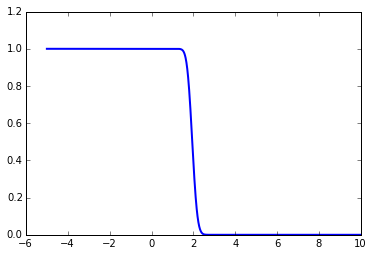

In [119]:
plot(n30.tables[9968][0], n30.tables[9968][1], lw=2.0)

In [92]:
# 32 and under nodes need to quantize rate/blocklength further
minb = 30 * 160 * 7 / 4
print(minb)
bitrange = arange(minb, 20000-minb, 21)
print(len(bitrange))
print(len(arange(minb, 20000-minb, 32)))

print(min2b)
min2b = 1 * 160 * 7 / 4
print(len(arange(min2b, 20000-min2b, 194)))

8400.0
153
100
280.0
101


3.21


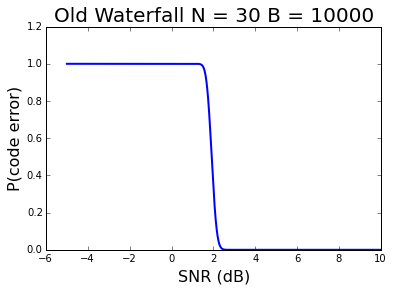

In [81]:
#For comparison

filename = hsrsscheme + '/n' + str(30) + '.in'
codetable = load_table(filename)
plot(codetable[0], codetable[1], lw=2.0)
title('Old Waterfall N = 30 B = 10000', fontsize=20)
xlabel('SNR (dB)', fontsize=16)
ylabel('P(code error)', fontsize=16)

print(codetable[0][np.where(np.array(codetable[1])<=10**(-10))[0][0]])

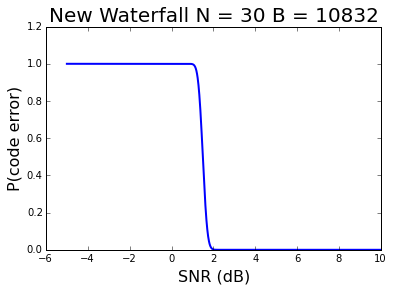

In [111]:
codetable_new = n30.tables[10832]
plot(codetable_new[0], codetable_new[1], lw=2.0)
title('New Waterfall N = 30 B = 10832', fontsize=20)
xlabel('SNR (dB)', fontsize=16)
ylabel('P(code error)', fontsize=16)

In [73]:
num_nodes = arange(1, 36)
minb = num_nodes*160*7/4
# print(minb)
testrange = arange(8400, 20000-8400, 21)
print('current', np.where(testrange == 9996))
print('cur', testrange[76])
# print(testrange)
rate = 30 * 160 / testrange * 7 / 4
blocklength = testrange / 21
k = (1-rate)*blocklength
msg = rate*blocklength
print(minb)
# test3 = collections.Counter(floor(k[::22])).most_common()
# print(len(list(test3)))

# for n in num_nodes:
#     filename = '../data_tables/lookup_0-01/n' + str(n) + '.in'
#     rate = n*160/10000
#     table = hs_rs_table(rate, blocklength)
#     save_table(table, filename)

('current', (array([76]),))
('cur', 9996)
[  280.   560.   840.  1120.  1400.  1680.  1960.  2240.  2520.  2800.
  3080.  3360.  3640.  3920.  4200.  4480.  4760.  5040.  5320.  5600.
  5880.  6160.  6440.  6720.  7000.  7280.  7560.  7840.  8120.  8400.
  8680.  8960.  9240.  9520.  9800.]


CPU times: user 7.82 s, sys: 191 ms, total: 8.01 s
Wall time: 9.03 s


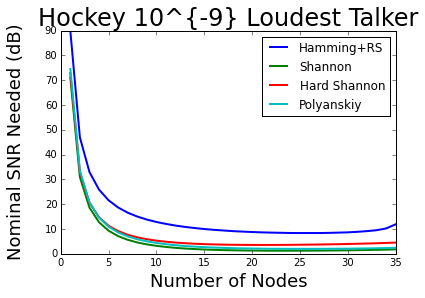

In [3]:
%%time
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = 0
start_nodes, end_nodes = 1, 36

shannonscheme = '../data_tables/shannon_tables'
hardshannonscheme = '../data_tables/hard_shannon_tables'
hsrsscheme = '../data_tables/hs_rs_downlink'
polyscheme = '../data_tables/polyanskiy_down'

shannon_down = loudest_talker(shannonscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
hardshannon_down = loudest_talker(hardshannonscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
hsrs_down = loudest_talker(hsrsscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
polyanskiy_down = loudest_talker(polyscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)

user_range = range(start_nodes, end_nodes)
plot(user_range, hsrs_down, lw=2.0, label='Hamming+RS')
plot(user_range, shannon_down, lw=2.0, label='Shannon')
plot(user_range, hardshannon_down, lw=2.0, label='Hard Shannon')
plot(user_range, polyanskiy_down, lw=2.0, label='Polyanskiy')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Loudest Talker', fontsize=24)
savefig('hockey_loudest.pdf', bbox='tight')

In [62]:
print([(x, hsrs_down[x]) for x in range(len(hsrs_down))])

[(0, 89.900000000009086), (1, 46.929999999999232), (2, 32.97000000000201), (3, 25.880000000001246), (4, 21.570000000000572), (5, 18.660000000000117), (6, 16.579999999999792), (7, 15.019999999999724), (8, 13.79999999999975), (9, 12.829999999999771), (10, 12.049999999999788), (11, 11.379999999999802), (12, 10.839999999999813), (13, 10.389999999999823), (14, 9.9899999999998315), (15, 9.6699999999998383), (16, 9.399999999999844), (17, 9.1399999999998496), (18, 8.9499999999998536), (19, 8.789999999999857), (20, 8.6399999999998602), (21, 8.5399999999998624), (22, 8.4699999999998639), (23, 8.3899999999998656), (24, 8.369999999999866), (25, 8.3799999999998658), (26, 8.369999999999866), (27, 8.4399999999998645), (28, 8.5399999999998624), (29, 8.64999999999986), (30, 8.8599999999998555), (31, 9.1399999999998496), (32, 9.5099999999998417), (33, 10.209999999999827), (34, 11.869999999999791)]
